Graphs
======
First, we implement the graph data structures so we can test the TSP algorithm. We implement the graph using the following approaches:
* Adjacency Matrix
* Edge List
* Euclidean Graph

In Euclidean graph, we assume our nodes are points in two dimensional Euclidean plane and the length of the edge between points $p$ and $q$ is $\left\lVert p-q \right\rVert_2$.

In [1]:
!pip install numpy scipy bqplot matplotlib

from math import sqrt
from typing import List, Tuple

class Graph:
    
    class Vertex:
        pass
    
    vertex_type = Vertex
    
    def __init__(self):
        raise NotImplemented
    
    def vertices(self) -> List[Vertex]:
        raise NotImplemented
    
    def distance(self, node1: Vertex, node2: Vertex) -> float:
        raise NotImplemented
        
    def permutation_to_cycle(self, permutation: List[int]) -> List[Vertex]:
        '''
        maps permutations to cycles of the grah.
        '''
        nodes = self.vertices()
        assert(len(nodes) == len(permutation))
        
        return [nodes[index] for index in permutation]
    
    def cycle_length(self, cycle: List[Vertex]) -> float:
        shifted_cycle = cycle[1:] + [cycle[0]]
        return sum([self.distance(n1, n2) for n1, n2 in zip(cycle, shifted_cycle)])
    
    def permutation_length(self, permutation: List[int]) -> float:
        return self.cycle_length(self.permutation_to_cycle(permutation))
    
    def num_vertices(self) -> int:
        return len(self.vertices())
        
class AdjacencyMatrixGraph(Graph):
    
    def __init__(self, adj):
        self.adj = adj
        
    def vertices(self):
        return range(len(self.adj))
    
    def distance(self, node1, node2):
        return self.adj[node1][node2]
    
    def num_vertices(self):
        return len(self.adj)
    

class EuclideanGraph(Graph):
    
    def __init__(self, points):
        self.pts = points
    
    def vertices(self):
        return [point for point in self.pts]

    def distance(self, node1, node2):
        dx = node1[0] -  node2[0]
        dy = node1[1] -  node2[1]
        return sqrt(dx*dx + dy*dy)
    
    def num_vertices(self):
        return len(self.pts)
    
class EdgeListGraph(Graph):
    
    def __init__(self, edge_list):
        self.edges = edge_list
        self.cache_num_vertices = len(self.vertices)
        
    def vertices(self):
        nodes = [self.edges[0] for edge in self.edges] + [self.edges[1] for edge in self.edges]
        unique_nodes = list(set(nodes))
        return (node for node in nodes)
    
    def distance(self, node1, node2):
        for n1, n2, dist in self.edges:
            if (node1 == n1 and node2 == n2) or (node2 == n1 and node1 == n2):
                return dist
        return float('inf')
    
    def num_vertices(self):
        return self.cache_num_vertices
    

In [2]:
import random
from collections import defaultdict
from copy import deepcopy

class GeneticAlgorithm:
    
    def __init__(self, population_size, mutation_probability, num_parents, max_iterations):
        self.population_size = population_size
        self.mutation_probability = mutation_probability
        self.num_parents = num_parents
        self.max_iterations = max_iterations
    
    def population_init(self):
        raise NotImplementedError
        
    def mutate(self, chromosome):
        raise NotImplementedError
        
    def cross(self, chromosome1, chromosome2):
        raise NotImplementedError
        
    def select_parents(self, population, num_pairs):
        total_fitness = sum([fitness for fitness, individual in population])
        rands = [random.random() for _ in range(2 * num_pairs)]
        cumulative_fitness = 0
        parents = []
        for individual_fitness_raw, individual in population:
            individual_fitness = individual_fitness_raw / total_fitness
            for rand in rands:
                if cumulative_fitness < rand <= (cumulative_fitness + individual_fitness):
                    parents.append(individual)
            cumulative_fitness += individual_fitness
        return zip(parents[::2], parents[1::2])
    
    def survival_selection(self, population, num_survivors):
        def sort_func(pop_item):
            fitness, individual = pop_item
            return fitness
        
        if num_survivors >= len(population):
            return population
        else:
            sorted_population = sorted(population, key=sort_func)
            return sorted_population[len(sorted_population) - num_survivors:]
    
    def run(self):
        current_population = self.population_init()
        
        average_fitness_values = []
        max_fitness_values = []
        sample_solutions = []
        self.init_run()
        
        for i in range(self.max_iterations):
            
            max_fitness_values.append(current_population[-1][0])
            average_fitness_values.append(self.average_fitness(current_population))
            self.process_population(current_population)
                
            parents = list(self.select_parents(current_population, self.num_parents))
            children = sum([self.cross(p1, p2) for (p1, p2) in parents], []) # flatten the list of children
            if random.random() < self.mutation_probability:
                children = [self.mutate(child) for child in children]
            children_with_fitness = [(self.fitness(child), child) for child in children]
            current_population += children_with_fitness
            current_population = self.survival_selection(current_population, self.population_size)
            sample_solutions.append(current_population[-1][1])
        return (current_population[-1], (average_fitness_values,
                                         max_fitness_values), sample_solutions, self.extra_results())
    
    def average_fitness(self, population):
        return sum([fitness for (fitness, _) in population]) / len(population)

        
    def init_run(self):
        pass
       
    def process_population(self, population):
        pass
    
    def extra_results(self):
        pass
    
    def fitness(self, individual):
        '''
        Must be positive. Objective is maximizing the fitness.
        '''
        raise NotImplementedError
    
class TSPGeneticAlgorithm(GeneticAlgorithm):
    
    def __init__(self, graph, population_size, mutation_probability, num_parents, max_iterations):
        super().__init__(population_size, mutation_probability, num_parents, max_iterations)
        self.graph = graph
    
    def population_init(self):
        res = []
        num_vertices = self.graph.num_vertices()
        for _ in range(self.population_size):
            p = list(range(num_vertices))
            random.shuffle(p)
            # res.append((p, self.fitness(p)))
            res.append((self.fitness(p), p))
        return res
    
    def fitness(self, chromosome):
        return 1 / (self.graph.permutation_length(chromosome))
    
    def init_run(self):
        self.average_edges = []
    
    def process_population(self, population):
        ps = population_size = len(population)
        cs = cycle_size = len(population[0][1])
        edge_counts = defaultdict(int)
        
        def ne(i):
            return (i+1) % cs
        
        for fitness, permutation in population:
            for i in range(len(permutation)):
                n1 = permutation[i]
                n2 = permutation[ne(i)]
                edge_counts[(min(n1, n2), max(n1, n2))] += 1
        self.average_edges.append(edge_counts)
    
    def extra_results(self):
        return self.average_edges
    
    def mutate(self, chromosome):
        copy = deepcopy(chromosome)
        if random.random() < self.mutation_probability:
            i, j = random.randrange(len(chromosome)), random.randrange(len(chromosome))
            copy[i], copy[j] = copy[j], copy[i]
        return copy
    
    def cross(self, chromosome1, chromosome2):
        chromosome_length  = len(chromosome1)
        index = random.randrange(chromosome_length)
        child1 = chromosome1[:index]
        child2 = chromosome2[:index]
        
        for i in range(chromosome_length):
            current_index = (index + i) % chromosome_length
            if chromosome1[current_index] not in child2:
                child2.append(chromosome1[current_index])
                
            if chromosome2[current_index] not in child1:
                child1.append(chromosome2[current_index])
        return [child1, child2]

In [3]:
import matplotlib.pyplot as plt

num_points = 15
random_points = [(random.random() * 10, random.random() * 10) for _ in range(num_points)]
graph = EuclideanGraph(random_points)

In [4]:
num_iterations = 1000
population_size = 100
tsp = TSPGeneticAlgorithm(graph, population_size, 1, 10, num_iterations)

res, (average_fitness_values, max_fitness_values), sample_solutions, edge_counts = tsp.run()
print(res)

(0.0317203809150311, [12, 10, 11, 4, 6, 7, 0, 5, 14, 9, 3, 2, 1, 8, 13])


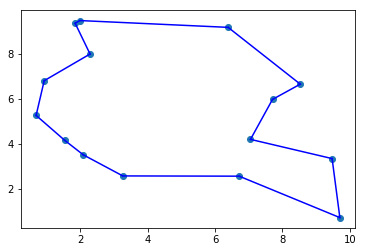

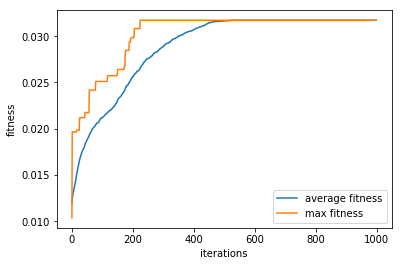

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure()
# fig, ax = plt.subplot()
ax = plt.subplot()

plt.scatter([x for x, y in random_points],[y for x, y in random_points] )

cycle_indices = res[1]
shifted_indices = cycle_indices[1:] + [cycle_indices[0]]

for p1, p2 in zip(cycle_indices, shifted_indices):
    p1 = random_points[p1]
    p2 = random_points[p2]
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='b')
    
fig = plt.figure()
plt.xlabel("iterations")
plt.ylabel("fitness")
plt.plot([i for i in range(len(average_fitness_values))], average_fitness_values, label="average fitness");
plt.plot([i for i in range(len(max_fitness_values))], max_fitness_values, label="max fitness");
plt.legend()

In [6]:
from bqplot import (Lines, Axis, Figure, Scatter, Scale, LinearScale, OrdinalScale)
from IPython.display import display
from ipywidgets import interact, HBox

x_scale_fitness = LinearScale()
y_scale_fitness = LinearScale()

x_scale = LinearScale()
y_scale = LinearScale()

fitness_values = max_fitness_values

scales = {'x': x_scale, 'y': y_scale}
scales_fitness = {'x': x_scale_fitness, 'y': y_scale_fitness}

solution_lines = [Lines(x=[0,0], y=[0,0], scales=scales, colors=["black"])
                  for _ in range(len(random_points))]
points = Scatter(x=[x for x,y in random_points],
                 y=[y for x,y in random_points],
                 scales=scales, colors=["red"])
average_fitness_plot = Lines(x=list(range(num_iterations)),
                            y=[f for f in average_fitness_values],
                             scales=scales_fitness, colors=["blue"],
                             display_legend=True, labels=["Average Fitness"])

max_fitness_plot = Lines(x=list(range(num_iterations)),
                         y=[f for f in max_fitness_values],
                         scales=scales_fitness, colors=["green"],
                         display_legend=True, labels=["Maximum Fitness"])

#average_fitness_point = Scatter(x=[0], y=[0], scales=scales_fitness, colors=["red"])
average_fitness_point = Scatter(x=[0], y=[0], scales=scales_fitness, colors=["red"])
max_fitness_point = Scatter(x=[0], y=[0], scales=scales_fitness, colors=["red"])

ax_x_fitness = Axis(scale=x_scale_fitness, label='iteration')
ax_y_fitness = Axis(scale=y_scale_fitness, label='fitness', orientation='vertical')

ax_x = Axis(scale=x_scale, label='x')
ax_y = Axis(scale=y_scale, label='y', orientation="vertical")

interactive_fig = Figure(marks = solution_lines + [points],
                        axes=[ax_x, ax_y], title="Best Solution of Iteration")
fitness_fig = Figure(marks = 
                     [average_fitness_plot, max_fitness_plot,
                     average_fitness_point, max_fitness_point],
                     axes=[ax_x_fitness, ax_y_fitness], legend_location="bottom-right")

display(HBox([interactive_fig, fitness_fig]))

def update_fig(iteration):
    sol = list(sample_solutions[iteration])
    edges = list(zip(sol, sol[1:] + [sol[0]]))
    for line, (i, j) in zip(solution_lines, edges):
        p,q = random_points[i], random_points[j]
        line.x = [p[0], q[0]]
        line.y = [p[1], q[1]]
        
    max_fitness_point.x = [iteration]
    max_fitness_point.y = [max_fitness_values[iteration]]
    
    average_fitness_point.x = [iteration]
    average_fitness_point.y = [average_fitness_values[iteration]]

interact(update_fig, iteration=(0,num_iterations-1));

interactive(children=(IntSlider(value=499, description='iteration', max=999), Output()), _dom_classes=('widget…

In [7]:
from bqplot import (Lines, Axis, Figure, Scatter, Scale, LinearScale, OrdinalScale)
from IPython.display import display
from ipywidgets import interact, HBox

x_scale_fitness = LinearScale()
y_scale_fitness = LinearScale()

x_scale = LinearScale()
y_scale = LinearScale()

fitness_values = max_fitness_values

scales = {'x': x_scale, 'y': y_scale}
scales_fitness = {'x': x_scale_fitness, 'y': y_scale_fitness}

# solution_lines = [Lines(x=[0,0], y=[0,0], scales=scales, colors=["black"])
#                   for _ in range(len(random_points))]

def grayscale_color_to_string(c):
    int_val = int(c * 255)
    hex_str = hex(int_val)[2:]
    if len(hex_str) == 1:
        hex_str = '0' + hex_str
    return "#" + hex_str * 3

solution_lines_dict = dict()

for i in range(num_points):
    for j in range(i+1, num_points):
        solution_lines_dict[(i, j)] = Lines(x=[random_points[i][0], random_points[j][0]],
                                            y = [random_points[i][1], random_points[j][1]],
                                            scales=scales, colors=["#ffffff"])

points = Scatter(x=[x for x,y in random_points],
                 y=[y for x,y in random_points],
                 scales=scales, colors=["red"])
average_fitness_plot = Lines(x=list(range(num_iterations)),
                            y=[f for f in average_fitness_values],
                             scales=scales_fitness, colors=["blue"],
                             display_legend=True, labels=["Average Fitness"])

max_fitness_plot = Lines(x=list(range(num_iterations)),
                         y=[f for f in max_fitness_values],
                         scales=scales_fitness, colors=["green"],
                         display_legend=True, labels=["Maximum Fitness"])

#average_fitness_point = Scatter(x=[0], y=[0], scales=scales_fitness, colors=["red"])
average_fitness_point = Scatter(x=[0], y=[0], scales=scales_fitness, colors=["red"])
max_fitness_point = Scatter(x=[0], y=[0], scales=scales_fitness, colors=["red"])

ax_x_fitness = Axis(scale=x_scale_fitness, label='iteration')
ax_y_fitness = Axis(scale=y_scale_fitness, label='fitness', orientation='vertical')

ax_x = Axis(scale=x_scale, label='x')
ax_y = Axis(scale=y_scale, label='y', orientation="vertical")

interactive_fig = Figure(marks = list(solution_lines_dict.values()) + [points],
                        axes=[ax_x, ax_y], title="Average Solution of Iteration")
fitness_fig = Figure(marks = 
                     [average_fitness_plot, max_fitness_plot,
                     average_fitness_point, max_fitness_point],
                     axes=[ax_x_fitness, ax_y_fitness], legend_location="bottom-right")

display(HBox([interactive_fig, fitness_fig]))

def update_fig(iteration):
    sol = list(sample_solutions[iteration])
    edges = list(zip(sol, sol[1:] + [sol[0]]))
#     for line, (i, j) in zip(solution_lines, edges):
#         p,q = random_points[i], random_points[j]
#         line.x = [p[0], q[0]]
#         line.y = [p[1], q[1]]
    total_edge_count =  100 # population size
    for i in range(num_points):
        for j in range(i+1, num_points):
            count = edge_counts[iteration][(i, j)]
            amt = count / total_edge_count
            current_line = solution_lines_dict[(i, j)]
            current_line.colors = [grayscale_color_to_string(1 - count / total_edge_count)]
            if amt < 0.01:
                current_line.visible = False
            else:
                current_line.visible = True
                
            
#     for (i, j), count in edge_counts[iteration].items():
#         float_color = count / total_edge_count
#         current_line = solution_lines_dict[(i, j)]
        #current_line.colors = [grayscale_color_to_string(float_color)]
        
        
    max_fitness_point.x = [iteration]
    max_fitness_point.y = [max_fitness_values[iteration]]
    
    average_fitness_point.x = [iteration]
    average_fitness_point.y = [average_fitness_values[iteration]]

interact(update_fig, iteration=(0,num_iterations-1));

interactive(children=(IntSlider(value=499, description='iteration', max=999), Output()), _dom_classes=('widget…